In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

import os
import sys
import re
import pdb
import glob

sys.path.insert(0, '/Users/jkinney/github/anylogo/')
sys.path.append('../src')
#sys.path.append('/Users/jkinney/github/anylogo')
import utils
from anylogo import logomaker
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
# Load ratios
in_file = '../output/ratios_9nt_ss_locus.txt'
df = pd.read_csv(in_file,sep='\t')
df.set_index('ss',inplace=True,drop=True)
site_length = len(df.index[0])    

In [3]:
# Normalize each column by consens sequence value
cons_seq = 'CAGGUAAGU'
for col in df.columns:
    df.loc[:,col] = 100*df.loc[:,col]/df.loc[cons_seq,col]

In [6]:
# Compute feature vectors for each single position
bases = 'ACGU'
variable_positions = np.array([0,1,2,5,6,7,8])

snp_df = pd.DataFrame(index=df.index)
for i in variable_positions:
    for b in bases:
        col_name = '%d%s'%(i,b)
        snp_df.loc[:,col_name] = [float(ss[i]==b) for ss in df.index]

print len(snp_df)
snp_df.head()

32768


,0A,0C,0G,0U,1A,1C,1G,1U,2A,2C,...,6G,6U,7A,7C,7G,7U,8A,8C,8G,8U
ss,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAA,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAAGCAAAC,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAAGCAAAG,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
AAAGCAAAU,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AAAGCAACA,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
# Compute feature vector for all pairs of positions
pair_df = pd.DataFrame(index=snp_df.index)
for i in variable_positions:
    for j in variable_positions:
        if j > i:
            for b in bases:
                for c in bases:
                    pos1_col = '%d%s'%(i,b)
                    pos2_col = '%d%s'%(j,c)
                    pair_col = '%s_%s'%(pos1_col,pos2_col)
                    pair_df.loc[:,pair_col] = snp_df.loc[:,pos1_col]*snp_df.loc[:,pos2_col]
pair_df.head()

,0A_1A,0A_1C,0A_1G,0A_1U,0C_1A,0C_1C,0C_1G,0C_1U,0G_1A,0G_1C,...,7C_8G,7C_8U,7G_8A,7G_8C,7G_8G,7G_8U,7U_8A,7U_8C,7U_8G,7U_8U
ss,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAU,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAACA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Drop nan rows
measurements = df['brca2_9nt'].dropna()

# Keep only GU splice sites
indices = [ss[3:5]=='GU' for ss in measurements.index]
measurements = measurements[indices]

# Filter for substantial values
splicing_threshod = 20
measurements = measurements[measurements >= splicing_threshod]
len(measurements)

X = pair_df.loc[measurements.index,:]
X.shape

(1185, 336)

In [65]:
# Do linear regression with small rige penalty to fix gauge
from sklearn import linear_model
reg = linear_model.Ridge (alpha = .0001)
reg.fit (X.values, measurements.values)

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

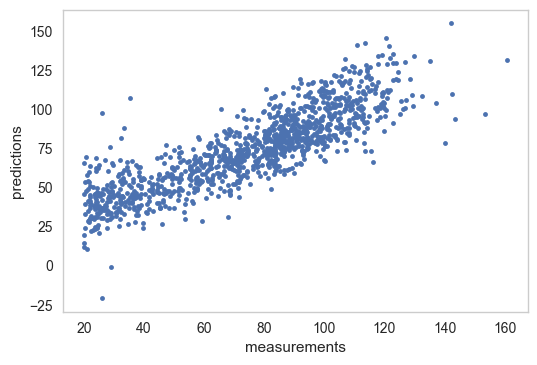

In [66]:
plt.plot(measurements, reg.predict(X), '.')
plt.xlabel('measurements')
plt.ylabel('predictions')

In [67]:
# Plot coefficients
effect_vec = pd.DataFrame(index=pair_df.columns)
effect_vec['value'] = reg.coef_
all_cols =np.ravel([['%d%s'%(i,b) for b in bases] for i in range(0,9)])

effect_mat = pd.DataFrame(index=all_cols, columns=all_cols).fillna(0)
for pair in effect_vec.index:
    pos1, pos2 = pair.split('_')
    effect_mat.loc[pos1,pos2] = effect_vec.loc[pair,'value']
    effect_mat.loc[pos2,pos1] = effect_vec.loc[pair,'value']
effect_mat.head()

,0A,0C,0G,0U,1A,1C,1G,1U,2A,2C,...,6G,6U,7A,7C,7G,7U,8A,8C,8G,8U
0A,0.000000,0.000000,0.000000,0.000000,9.683908,11.757162,-8.129641,1.865949,7.521833,14.737666,...,2.226947,4.287128,1.640924,9.904932,-12.562011,16.193532,4.641432,2.786067,0.931447,6.818431
0C,0.000000,0.000000,0.000000,0.000000,14.179143,-4.128639,10.979795,-3.017742,9.153135,14.040713,...,3.399871,-0.589938,3.645712,4.624768,-5.150579,14.892656,4.021268,3.429595,3.984062,6.577632
0G,0.000000,0.000000,0.000000,0.000000,19.383994,-9.033918,-11.154993,-14.780964,-12.966211,-5.602714,...,-15.197578,1.203900,-9.676888,-9.168458,-4.661068,7.920533,-7.029993,-6.632038,-7.912417,5.988567
0U,0.000000,0.000000,0.000000,0.000000,-1.978009,0.315408,-3.416802,-12.524651,-1.773575,-2.296911,...,-9.367055,-9.241931,-8.207306,-4.722759,-4.124464,-0.549524,-8.815361,-9.120359,-2.828243,3.159910
1A,9.683908,14.179143,19.383994,-1.978009,0.000000,0.000000,0.000000,0.000000,18.512895,23.887123,...,11.697185,15.981017,10.696699,24.437289,-19.972537,26.107586,13.059024,10.908310,9.211634,8.090069


In [73]:
all_cols = ['%d%s'%(i,b) for i in range(0,9) for b in bases]
all_cols

['0A',
 '0C',
 '0G',
 '0U',
 '1A',
 '1C',
 '1G',
 '1U',
 '2A',
 '2C',
 '2G',
 '2U',
 '3A',
 '3C',
 '3G',
 '3U',
 '4A',
 '4C',
 '4G',
 '4U',
 '5A',
 '5C',
 '5G',
 '5U',
 '6A',
 '6C',
 '6G',
 '6U',
 '7A',
 '7C',
 '7G',
 '7U',
 '8A',
 '8C',
 '8G',
 '8U']

In [87]:
annotation_df = pd.DataFrame(columns=['pos','base'],
                             data=[[str(i),str(b)] for i in range(0,9) for b in bases])


In [88]:
import seaborn as sns
from helper_functions import gelx, gely

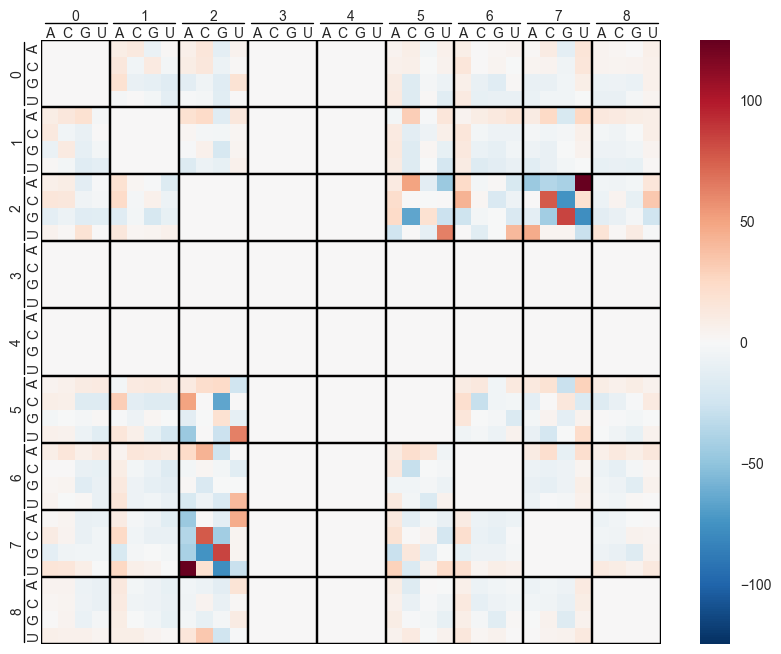

In [91]:
fig, ax = plt.subplots(figsize=[10,8])
sns.heatmap(effect_mat)
for i in range(len(effect_mat)+1):
    if i%4==0:
        ax.axhline(i, color='k')
        ax.axvline(i, color='k')
gelx(ax, annotation_df, annotation_spacing=1, fontsize=10)
gely(ax, annotation_df, annotation_spacing=1, fontsize=10)
